**What is the sentiment of the verses of the crosswalks in Madrid using [twitter-XLM-roBERTa-base for Emotion Analysis](https://huggingface.co/daveni/twitter-xlm-roberta-emotion-es)?**

This is a XLM-roBERTa-base model trained on ~198M tweets and finetuned for emotion analysis on Spanish language. This model was presented to EmoEvalEs competition, part of IberLEF 2021 Conference, where the proposed task was the classification of Spanish tweets between seven different classes: anger, disgust, fear, joy, sadness, surprise, and other. We achieved the first position in the competition with a macro-averaged F1 score of 71.70%. 

**Setup**

In [ ]:
!pip install 'transformers[torch]'

In [ ]:
!pip install pandas

In [ ]:
!pip install matplotlib

**Usage**

In [4]:
from transformers import pipeline

print(pipeline('sentiment-analysis')('we love you'))

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'POSITIVE', 'score': 0.9998704195022583}]


In [5]:
emotion_analysis = pipeline("text-classification", framework="pt", model="daveni/twitter-xlm-roberta-emotion-es")
emotion_analysis("Te quiero. Te amo.")

[{'label': 'joy', 'score': 0.9090800285339355}]

**On the basis of the results of the OpenAI**

In [6]:
import pandas as pd

versos_al_paso_geo_file_path = './output/versosalpaso_sentiment_text-davinci-003_geo.csv'
versos_al_paso_spanish_sentiment_geo = pd.read_csv(versos_al_paso_geo_file_path, sep=';', encoding='utf-8')
versos_al_paso_spanish_sentiment_geo.columns

Index(['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso',
       'direccion', 'sentiment', 'quarter', 'district', 'city'],
      dtype='object')

**Rename the column** for the associated sentiment using OpenAI

In [7]:
versos_al_paso_spanish_sentiment_geo.columns = ['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso', 'direccion', 
                                            'openai_sentiment',
                                            'quarter', 'district', 'city']
versos_al_paso_spanish_sentiment_geo.columns

Index(['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso',
       'direccion', 'openai_sentiment', 'quarter', 'district', 'city'],
      dtype='object')

In [8]:
versos_al_paso_spanish_sentiment_geo[0:1]

,Unnamed: 0,id,latitud,longitud,autor,barrio,verso,direccion,openai_sentiment,quarter,district,city
0,0,1000,40.425239,-3.691217,﻿Mario Vaillo de Mingo,﻿CENTRO,Quizá el secreto de la vida tan solo consista ...,﻿Calle de Génova-Plaza Colón,positive,Justicia,Centro,Madrid


**Adding** results

In [12]:
twitter_xlm_sentiment_analysis = pd.DataFrame(versos_al_paso_spanish_sentiment_geo.verso)
twitter_xlm_sentiment_analysis['twitter-xml_sentiment'] = ''

sentiments_by_lib = [ 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'others', 'as_positive', 'as_neutral', 'as_negative' ]
for sentiment in sentiments_by_lib:
    twitter_xlm_sentiment_analysis[f'twitter-xml_{sentiment}'] = 0.0

twitter_xlm_sentiment_analysis.columns

Index(['verso', 'twitter-xml_sentiment', 'twitter-xml_anger',
       'twitter-xml_disgust', 'twitter-xml_fear', 'twitter-xml_joy',
       'twitter-xml_sadness', 'twitter-xml_surprise', 'twitter-xml_others',
       'twitter-xml_as_positive', 'twitter-xml_as_neutral',
       'twitter-xml_as_negative'],
      dtype='object')

In [15]:
import math

def get_sentiment_summary(anger: float, disgust: float, fear: float, joy: float, sadness: float, surprise: float, other: float) -> str:
    sentiments = { 
        'positive': joy,
        'negative': anger + disgust + fear + sadness,
        'neutral': surprise + other
    }

    sentiment = max(sentiments, key=sentiments.get)
    sentiments['sentiment'] = sentiment
    return sentiments

for i, row in twitter_xlm_sentiment_analysis.iterrows():
    verse = row.verso
    print(i, end='\r')

    emotions = emotion_analysis(verse)
    for emotion in emotions:
        twitter_xlm_sentiment_analysis.at[i, f'twitter-xml_{emotion["label"]}'] = emotion["score"]


    sentiment_summary = get_sentiment_summary(
        twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_anger'],
        twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_disgust'],
        twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_fear'],
        twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_joy'],
        twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_sadness'],
        twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_surprise'],
        twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_others']
    )

    twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_sentiment'] = sentiment_summary['sentiment']
    twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_as_positive'] = sentiment_summary['positive']
    twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_as_neutral'] = sentiment_summary['neutral']
    twitter_xlm_sentiment_analysis.at[i, 'twitter-xml_as_negative'] = sentiment_summary['negative']


In [16]:
twitter_xlm_sentiment_analysis[0:1]

,verso,twitter-xml_sentiment,twitter-xml_anger,twitter-xml_disgust,twitter-xml_fear,twitter-xml_joy,twitter-xml_sadness,twitter-xml_surprise,twitter-xml_others,twitter-xml_as_positive,twitter-xml_as_neutral,twitter-xml_as_negative
0,Quizá el secreto de la vida tan solo consista ...,neutral,0.0,0.0,0.0,0.0,0.0,0.0,0.709521,0.0,0.709521,0.0


Saving it

In [17]:
versos_al_paso_spanish_sentiment = versos_al_paso_spanish_sentiment_geo.copy()

In [18]:
for colname in twitter_xlm_sentiment_analysis.columns:
    if 'verso' == colname:
        continue

    versos_al_paso_spanish_sentiment[colname] = twitter_xlm_sentiment_analysis[colname]

versos_al_paso_spanish_sentiment.columns

Index(['Unnamed: 0', 'id', 'latitud', 'longitud', 'autor', 'barrio', 'verso',
       'direccion', 'openai_sentiment', 'quarter', 'district', 'city',
       'twitter-xml_sentiment', 'twitter-xml_anger', 'twitter-xml_disgust',
       'twitter-xml_fear', 'twitter-xml_joy', 'twitter-xml_sadness',
       'twitter-xml_surprise', 'twitter-xml_others', 'twitter-xml_as_positive',
       'twitter-xml_as_neutral', 'twitter-xml_as_negative'],
      dtype='object')

In [19]:
versos_al_paso_spanish_sentiment[0:1]

,Unnamed: 0,id,latitud,longitud,autor,barrio,verso,direccion,openai_sentiment,quarter,...,twitter-xml_anger,twitter-xml_disgust,twitter-xml_fear,twitter-xml_joy,twitter-xml_sadness,twitter-xml_surprise,twitter-xml_others,twitter-xml_as_positive,twitter-xml_as_neutral,twitter-xml_as_negative
0,0,1000,40.425239,-3.691217,﻿Mario Vaillo de Mingo,﻿CENTRO,Quizá el secreto de la vida tan solo consista ...,﻿Calle de Génova-Plaza Colón,positive,Justicia,...,0.0,0.0,0.0,0.0,0.0,0.0,0.709521,0.0,0.709521,0.0


In [20]:
versos_al_paso_spanish_sentiment_file_path = './output/versosalpaso_twitter-XLM-roBERTa-base.csv'
versos_al_paso_spanish_sentiment.to_csv(versos_al_paso_spanish_sentiment_file_path, sep=';', encoding='utf-8')

**A pie chart for sentiment values**

In [21]:
df = versos_al_paso_spanish_sentiment.groupby(['twitter-xml_sentiment'])['twitter-xml_sentiment'].count()
df

twitter-xml_sentiment
negative    235
neutral     780
positive     85
Name: twitter-xml_sentiment, dtype: int64

<Axes: title={'center': 'Sentiments'}>

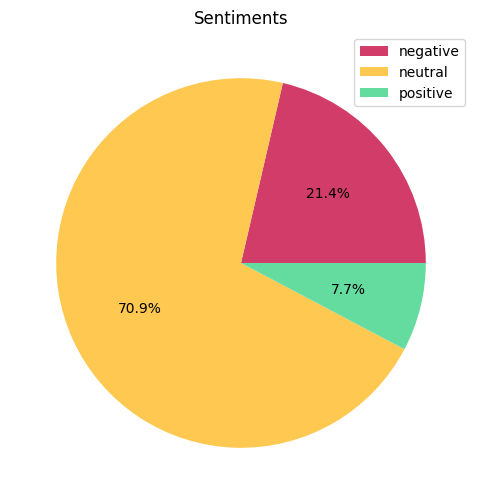

In [22]:
colors = ['#D23C69','#FFC850','#64DCA0']
df.plot.pie(legend=True, title='Sentiments', autopct='%1.1f%%', colors=colors, ylabel='', labeldistance=None, figsize=(6, 6))

**A horizontal bar chart by district**

In [23]:
table_by_barrio = pd.pivot_table(versos_al_paso_spanish_sentiment[['district', 'twitter-xml_sentiment']], index='district', columns='twitter-xml_sentiment', aggfunc=len, fill_value=0)
table_by_barrio

twitter-xml_sentiment,negative,neutral,positive
district,,,
Arganzuela,12,38,3
Barajas,2,8,1
Carabanchel,20,56,5
Centro,13,50,7
Chamartín,14,54,7
Chamberí,11,46,7
Ciudad Lineal,15,58,5
Fuencarral-El Pardo,16,45,4
Hortaleza,8,43,5


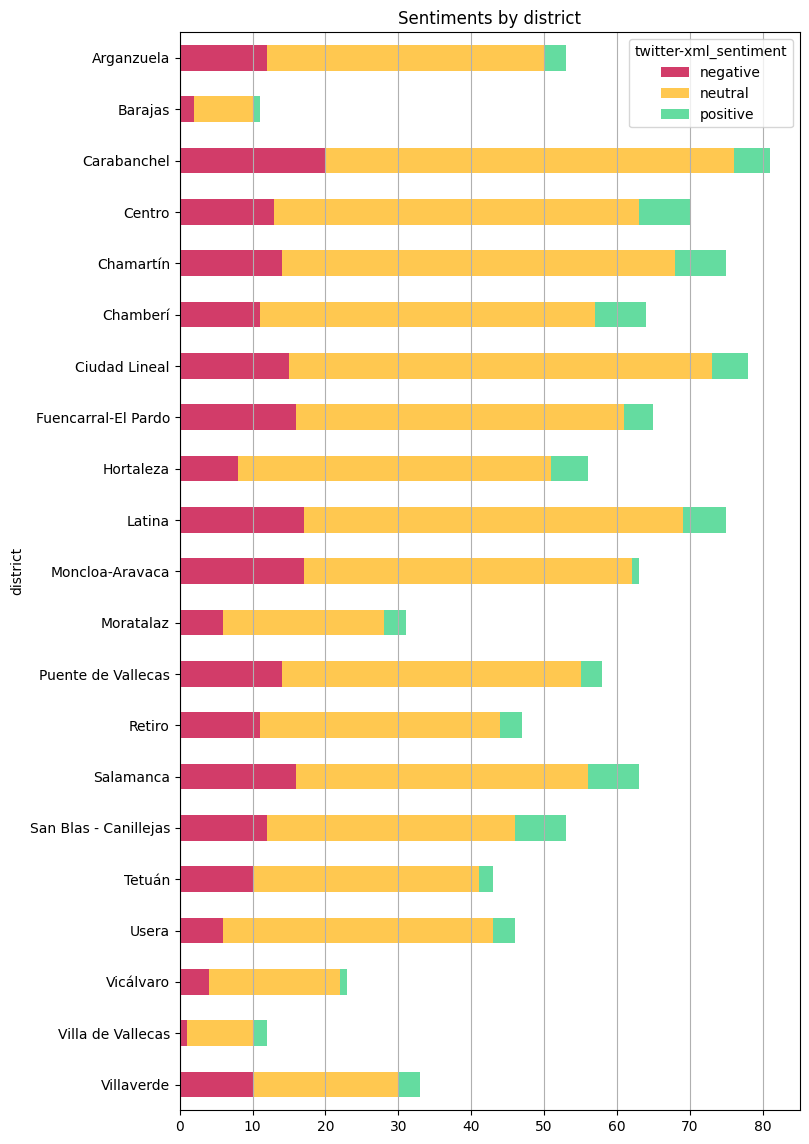

In [24]:
import matplotlib.pyplot as plt

colors = {'negative': '#D23C69', 'neutral': '#FFC850', 'positive': '#64DCA0'}
ax = table_by_barrio.plot.barh(color=colors, title='Sentiments by district', figsize=(8, 14), grid=True, stacked=True)
ax.invert_yaxis()
ax.grid(axis='y')

**Show all rows and full column content**

In [25]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

**Taking a look** to the verses

**OpenAI vs. library**

In [26]:
openai_says_negative = versos_al_paso_spanish_sentiment[versos_al_paso_spanish_sentiment.openai_sentiment.eq('negative')]
openai_diffs = openai_says_negative[openai_says_negative['twitter-xml_sentiment'] != 'negative']
openai_diffs[['district', 'verso', 'openai_sentiment', 'twitter-xml_sentiment', 'twitter-xml_anger', 'twitter-xml_disgust',
              'twitter-xml_fear', 'twitter-xml_joy', 'twitter-xml_sadness', 'twitter-xml_surprise', 'twitter-xml_others']]

,district,verso,openai_sentiment,twitter-xml_sentiment,twitter-xml_anger,twitter-xml_disgust,twitter-xml_fear,twitter-xml_joy,twitter-xml_sadness,twitter-xml_surprise,twitter-xml_others
8,Tetuán,La política tiene colgado el cartel de rebajas,negative,neutral,0.0,0.0,0.0,0.000000,0.0,0.0,0.811755
110,Salamanca,"No hay nada más bello que lo que nunca he tenido, nada más amado que lo que perdí.",negative,positive,0.0,0.0,0.0,0.518322,0.0,0.0,0.000000
247,Tetuán,La cobardía se mide en ojalases..,negative,neutral,0.0,0.0,0.0,0.000000,0.0,0.0,0.459702
270,Chamberí,- El sermón del predicador es la oración del necio,negative,neutral,0.0,0.0,0.0,0.000000,0.0,0.0,0.891215
419,Villa de Vallecas,Lanzaré a tu noche oscura los dados de mis dudas,negative,neutral,0.0,0.0,0.0,0.000000,0.0,0.0,0.777454
427,Villaverde,¿Quién puede amar con la garganta rota?,negative,neutral,0.0,0.0,0.0,0.000000,0.0,0.0,0.563851
600,Carabanchel,Si el monstruo te da miedo ¿Por Qué le das de comer?,negative,neutral,0.0,0.0,0.0,0.000000,0.0,0.0,0.491027


**Library vs. OpenAI**

In [27]:
def lib_vs_openai(sentiment: str) -> pd.DataFrame:
    lib_says = versos_al_paso_spanish_sentiment[versos_al_paso_spanish_sentiment['twitter-xml_sentiment'] == sentiment]
    return lib_says[['district', 'verso', 'twitter-xml_sentiment', 'openai_sentiment', 'twitter-xml_anger', 'twitter-xml_disgust',
              'twitter-xml_fear', 'twitter-xml_joy', 'twitter-xml_sadness', 'twitter-xml_surprise', 'twitter-xml_others']]

In [28]:
looks_like_negative = lib_vs_openai('negative')

In [29]:
looks_like_negative[looks_like_negative.openai_sentiment.eq('negative')].sort_values('district')

,district,verso,twitter-xml_sentiment,openai_sentiment,twitter-xml_anger,twitter-xml_disgust,twitter-xml_fear,twitter-xml_joy,twitter-xml_sadness,twitter-xml_surprise,twitter-xml_others
112,Arganzuela,Quizás lo que nos salva son los raros momentos en que no pasa nada.,negative,negative,0.000000,0.0,0.0,0.0,0.431237,0.0,0.0
602,Carabanchel,Cuídate del recuerdo.,negative,negative,0.000000,0.0,0.0,0.0,0.926267,0.0,0.0
104,Centro,La tristeza es vulgar si no es inmensa y esconde muchas veces un placer venenoso,negative,negative,0.000000,0.0,0.0,0.0,0.878778,0.0,0.0
433,Fuencarral-El Pardo,En vez de pájaro en mano prefiero una gran desbandada en la cabeza,negative,negative,0.437024,0.0,0.0,0.0,0.000000,0.0,0.0
904,Fuencarral-El Pardo,Pecas. En todas sus acepciones.,negative,negative,0.000000,0.0,0.0,0.0,0.734532,0.0,0.0
174,Latina,Madrid me duele.,negative,negative,0.000000,0.0,0.0,0.0,0.887939,0.0,0.0
89,Moncloa-Aravaca,Nadie es un candidato tan popular para el agravio como una víctima,negative,negative,0.000000,0.0,0.0,0.0,0.397505,0.0,0.0
504,Moncloa-Aravaca,Algo está roto si el odio une tanto.,negative,negative,0.000000,0.0,0.0,0.0,0.479529,0.0,0.0
790,Moncloa-Aravaca,O me paras los pies o esto se me va de las manos.,negative,negative,0.458363,0.0,0.0,0.0,0.000000,0.0,0.0
14,Retiro,"Peladitos ven TV y quieren ser así, están aprendiendo a matar antes que a vivir",negative,negative,0.737375,0.0,0.0,0.0,0.000000,0.0,0.0


In [30]:
looks_like_negative[looks_like_negative.openai_sentiment != 'negative'].sort_values('district')

,district,verso,twitter-xml_sentiment,openai_sentiment,twitter-xml_anger,twitter-xml_disgust,twitter-xml_fear,twitter-xml_joy,twitter-xml_sadness,twitter-xml_surprise,twitter-xml_others
1009,Arganzuela,¿Vidas malvividas o quizá deudas de vidas ya vividas?,negative,positive,0.000000,0.0,0.0,0.0,0.867008,0.0,0.0
344,Arganzuela,Los insultos son como las balas. Solo duelen los que aciertan,negative,positive,0.000000,0.0,0.0,0.0,0.501119,0.0,0.0
934,Arganzuela,Ojalá algún día te hagas casualidad mientras camino por estas calles,negative,positive,0.000000,0.0,0.0,0.0,0.414785,0.0,0.0
933,Arganzuela,Voy a hacerte feliz. Sufrirá tanto que le pondrás mi nombre a la tristeza,negative,positive,0.000000,0.0,0.0,0.0,0.846339,0.0,0.0
731,Arganzuela,Mis huellas aún persiguen tu sombra,negative,positive,0.000000,0.0,0.0,0.0,0.606779,0.0,0.0
727,Arganzuela,Me duele la vida donde a otros les late el corazón.,negative,positive,0.000000,0.0,0.0,0.0,0.928412,0.0,0.0
664,Arganzuela,Difumínate conmigo antes de que todo muera,negative,positive,0.000000,0.0,0.0,0.0,0.497095,0.0,0.0
83,Arganzuela,Eres recuerdo blanco. Nada pesa entre mis manos y sin embargo te puedo retener,negative,positive,0.000000,0.0,0.0,0.0,0.416740,0.0,0.0
575,Arganzuela,"Pasar por la vida, no dejar que la vida pase.",negative,positive,0.000000,0.0,0.0,0.0,0.473988,0.0,0.0
576,Arganzuela,Si me voy has de saber que no salvé los muebles de tus llamas,negative,positive,0.000000,0.0,0.0,0.0,0.559029,0.0,0.0
